# Coding Assignment - 3
## MATH-GA 2805 Trends in Sell-Side Modelling
#### Abhishek Kulkarni (ask9103)
#### Lavaneesh Sharma (lss8875)

********

We continue with the interest rate setup from Coding Assignment 2. That is, we consider a market where we have established at time $0$ (e.g., by looking at quoted swap and futures prices) that the risk-free forward interest rate curve is given by 

$$f(0,t) = a + b.t$$

where $a=2.5\%\;\&\;b = 0.2\%$

The dynamics of the forward curve $f(t,T)$ are as in Coding Assignment 2: a 2-factor Gaussian model with $\sigma_{r}=2\%, c=40\%, \kappa_{2}=5\%, \rho_{\infty}=40\%$

We also consider, as in Coding Assignment 2, a 10-year semi-annual interest rate swap. Let the notional of the swap be $USD\;50\;million$ and let its coupon be $h$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import cos, exp, pi
from scipy.optimize import fsolve
import random
from scipy.stats import norm

In [2]:
class SwapPricer:
    
    def __init__(self,a,b,c,rho_inf,sig_r,k2,N,T_,ts_):
        self.a       =  a
        self.b       =  b
        self.c       =  c
        self.rho_inf =  rho_inf
        self.sig_r   =  sig_r
        self.k2      =  k2
        self.sig1    =  self.c * self.sig_r
        self.v       =  np.sqrt((1/self.c)**2 - 1 - 2*((self.rho_inf/self.c) - 1))
        self.sig2    =  self.v * self.sig1
        self.px      =  ((self.rho_inf/self.c) - 1)/(self.v)
        self.N       =  N
        self.T_      =  T_
        self.ts_     =  ts_
        self.dt_     =  self.T_[1] - self.T_[0]
    
    
    def y_mat(self,t_):
        y1 = (self.sig1**2)*t_ + \
        ( ( (self.px**2) * (self.sig1**2) * (self.sig2**2) * (np.exp(2*self.k2*t_) - 1) ) / (2*self.k2) )   
        
        y2 = (((self.sig1**2)*(self.sig2)*self.px )*( np.exp(self.k2*t_) - 1 ) + \
              ( (self.sig2**2) * (self.sig1) * (self.px)) * (np.exp(2*self.k2*t_) - 1)) * np.exp(-self.k2*t_)
        
        y3 = y2
        
        y4 = (((self.sig2**2)*(1 - np.exp(-2*k2*t_)))/(2*self.k2)) + \
        (((self.px**2) * (self.sig1**2) * (self.sig2**2)) * (1 - np.exp(-2*self.k2*t_)))/(2*self.k2)
        
        return y1, y2, y3, y4
    
    
    def simulations(self):
        X1 = np.zeros((self.N,len(self.ts_)))
        X2 = np.zeros((self.N,len(self.ts_)))
        X1[:,0] = 0
        X2[:,0] = 0
        
        dt = self.ts_[1] - self.ts_[0]
        dWx1 = np.random.normal(loc = 0,scale=np.sqrt(dt),size=(self.N,len(self.ts_)-1))
        dWx2 = np.random.normal(loc = 0,scale=np.sqrt(dt),size=(self.N,len(self.ts_)-1))
        dWx2 = self.px*dWx1 + dWx2*np.sqrt(1 - (self.px)**2)
        
        for i in range(0,len(self.ts_)-1):
            l0,l1,l2,l3 = self.y_mat(self.ts_[i])
            X1[:,i+1] = X1[:,i] + (l0 + l1)*dt + self.sig1*dWx1[:,i]
            X2[:,i+1] = X2[:,i] + (l2 + l3 - (self.k2*X2[:,i]))*dt + self.sig2*dWx2[:,i]
        
        return X1,X2
    
    
    def Plot(self,x1_,x2_):
        figure, axis = plt.subplots(2,1)
        figure.set_figwidth(20)
        figure.set_figheight(10)
        
        for i in range(self.N):
            axis[0].plot(self.ts_,x1_[i,:])
        axis[0].set_title("Two Factor OU Process")
        axis[0].set_ylabel("X1")
        axis[0].set_xlabel("Years")
        axis[0].grid(True)

        for i in range(self.N):
            axis[1].plot(self.ts_,x2_[i,:])
        axis[1].set_xlabel("Years")
        axis[1].set_ylabel("X2")
        axis[1].set_title("Two Factor OU Process")
        axis[1].grid(True)
        plt.show()
    
    
    def A_vec(self,t_):
        v1, v2, v3, v4 = self.y_mat(t_)
        Ttemp = self.T_[self.T_ > t_]
        ttemp = np.ones(len(Ttemp))*t_
        Tdelt = Ttemp - ttemp
        return -0.5*((Tdelt)**2)*v1 - \
        (v3/self.k2)*(Tdelt)*(1-np.exp(-self.k2*(Tdelt))) - \
    0.5*(v4/(self.k2)**2)*(1 - np.exp(-self.k2*(Tdelt)))**2
    
    
    def Pr(self,t_,x1_,x2_):
        Ttemp = self.T_[self.T_ > t_]
        ttemp = np.ones(len(Ttemp))*t_
        T_t = np.tile(Ttemp - ttemp, (self.N,1))
        A = np.tile(self.A_vec(t_), (self.N,1))
        P_0T = np.tile(np.exp(-(self.a*Ttemp + self.b*(Ttemp**2)/2)), (self.N,1))
        P_0t = np.tile(np.exp(-(self.a*ttemp + self.b*(ttemp**2)/2)), (self.N,1))
        t_index = np.where(self.ts_==t_)[0][0]
        CX   = x1_[:,t_index].reshape((self.N,1))*(-T_t) + \
        x2_[:,t_index].reshape((self.N,1))*(np.exp(-self.k2*(T_t)) - 1) / (self.k2)
        
        return (P_0T / P_0t) * np.exp(A + CX)
    
    
    def spot_rate(self,x1_,x2_):
        f_0t = np.tile(self.a + self.b*self.ts_,(self.N,1))
        return f_0t + x1_ + x2_
    
    
    def beta(self,t_,x1_,x2_):
        t_index = np.where(self.ts_==t_)[0][0]
        h = (t_-0)/(len(self.ts_[:t_index+1]))
        r = self.spot_rate(x1_,x2_)
        rt = r[:,:t_index+1]
        return np.exp((h/2)*(rt[:,0] + 2*np.sum(rt[:,1:len(rt)-1], axis=1) + rt[:,-1]))

    
    def StubVal(self,t_,x1_,x2_):
        if t_ in self.T_:
            return np.ones(self.N)
        else:    
            T0 = self.T_[self.T_ < t_][-1]
            return self.beta(t_,x1_,x2_) / self.beta(T0,x1_,x2_) 
    
    
    def SwapVal(self,x1_,x2_,c):
        swap = np.zeros((self.N,len(self.ts_)))
        for i in range(len(self.ts_)-1):
            disc_fact = self.Pr(self.ts_[i],x1_,x2_)
            agg_disc_fact = np.sum(disc_fact, axis=1) * c * self.dt_
            stub = self.StubVal(self.ts_[i],x1_,x2_)
            final_term = disc_fact[:,-1] 
            swap_value = agg_disc_fact - stub + final_term
            swap[:,i] = swap_value
        return swap
    

In [3]:
# MODEL PARAMETERS

a       = 0.025
b       = 0.002
sig_r   = 0.02
c       = 0.4
k2      = 0.05
rho_inf = 0.4

In [4]:
# OBSERVATION GRID
ts = np.arange(0,521)/52   # WEEKLY GRID

In [5]:
# SWAP DEFINITION

notional = 50000000         # SWAP NOTIONAL
maturity = 10               # MATURITY (in Yrs.)
T = np.linspace(0,10,21)    # PAYMENT DATES (in Yrs.)

In [6]:
# NO OF SIMULATIONS
N = 30000

In [7]:
model1 = SwapPricer(a,b,c,rho_inf,sig_r,k2,N,T,ts)
x1, x2 = model1.simulations()
#model1.Plot(x1,x2)

In [8]:
# FINDING h_par

def optimal_h(c):
    swap_price = model1.SwapVal(x1,x2,c)[0][0]
    return swap_price

h_par = fsolve(func=optimal_h, x0=0)[0]
print("Optimal value for coupon is :", h_par)

Optimal value for coupon is : 0.034721066827000255


*******

## Question 1

**In Coding Assignment 2, you established the expected exposure (EE) profile for uncollateralized par-valued payer and receiver swaps, on a weekly grid spanning $[0,10yrs]$. Repeat this exercise (for both payer and receiver swaps) for the $USD\;50\;million$ swap, using coupons of $h = 2\%, h = 4\%, h = 6\%, h = 8\%$. Graph these profiles (one figure for payer swaps and one figure for receiver swaps).**

In [9]:
h1 = np.array([0.02,0.04,0.06,0.08])

In [10]:
model3 = SwapPricer(a,b,c,rho_inf,sig_r,k2,N,T,ts)
x1_3, x2_3 = model3.simulations()
rates3 = model3.spot_rate(x1_3,x2_3)
#model3.Plot(x1_3, x2_3)

In [11]:
swap_prices_ = np.zeros(len(h1), dtype=object)
swap_prices_delta = np.zeros(len(h1), dtype=object)
pEE = np.zeros((len(h1),len(ts)), dtype=object)
rEE = np.zeros((len(h1),len(ts)), dtype=object)
pPVEE = np.zeros((len(h1),len(ts)), dtype=object)
rPVEE = np.zeros((len(h1),len(ts)), dtype=object)
pEE_VM = np.zeros((len(h1),len(ts)), dtype=object)
rEE_VM = np.zeros((len(h1),len(ts)), dtype=object)
pPVEE_VM = np.zeros((len(h1),len(ts)), dtype=object)
rPVEE_VM = np.zeros((len(h1),len(ts)), dtype=object)
pEE_VM_IM = np.zeros((len(h1),len(ts)), dtype=object)
rEE_VM_IM = np.zeros((len(h1),len(ts)), dtype=object)
pPVEE_VM_IM = np.zeros((len(h1),len(ts)), dtype=object)
rPVEE_VM_IM = np.zeros((len(h1),len(ts)), dtype=object)

In [12]:
def disc_factor(ts_):
    disc_factors = np.ones((N,len(ts_)))
    #rates = model3.spot_rate(x1_3,x2_3)[:,:np.where(ts==t)[0][0]+1]
    for i in range(len(ts_)):
        r = rates3[:,:np.where(ts_==ts_[i])[0][0]+1]
        h = (ts_[i]-0)/(len(ts_[:np.where(ts_==ts_[i])[0][0]+1]))
        disc_factors[:,i] = np.exp(-(h/2)*(r[:,0] + 2*np.sum(r[:,1:len(r)-1],axis=1) + r[:,-1]))
        
    return disc_factors

dfac = disc_factor(ts)
#dfac

In [13]:
p0 = 0.99
psi_p0 = (norm.pdf(norm.ppf(p0)) - norm.ppf(p0)*(1-p0))*np.sqrt(2*np.pi)
    
for i in range(len(h1)):
    swap_prices_[i] = model3.SwapVal(x1_3,x2_3,h1[i]) * notional
    spd = np.roll(swap_prices_[i], 2, axis=1)
    spd[:,:2] = np.zeros((len(spd),2))
    swap_prices_delta[i] = spd
    
    # Payer & Receiver EE(t) with no collateral
    pEE[i] = np.mean(np.maximum(-swap_prices_[i],0),axis=0)
    rEE[i] = np.mean(np.maximum(swap_prices_[i],0),axis=0)
    # Payer & Receiver PVEE with no collateral
    pPVEE[i] = np.mean(np.maximum(-swap_prices_[i],0)*dfac,axis=0) 
    rPVEE[i] = np.mean(np.maximum(swap_prices_[i],0)*dfac,axis=0) 
    # Payer & Receiver EE(t) with VM
    pEE_VM[i] = np.mean(np.maximum(-(swap_prices_[i]-swap_prices_delta[i]),0),axis=0) 
    rEE_VM[i] = np.mean(np.maximum((swap_prices_[i]-swap_prices_delta[i]),0),axis=0) 
    # Payer & Receiver PVEE with VM
    pPVEE_VM[i] = np.mean(np.maximum(-(swap_prices_[i]-swap_prices_delta[i])*dfac,0),axis=0) 
    rPVEE_VM[i] = np.mean(np.maximum((swap_prices_[i]-swap_prices_delta[i])*dfac,0),axis=0) 
    # Payer & Receiver EE(t) with VM & IM
    pEE_VM_IM[i] = np.mean(np.maximum(-(swap_prices_[i]-swap_prices_delta[i]),0),axis=0) * psi_p0
    rEE_VM_IM[i] = np.mean(np.maximum(swap_prices_[i]-swap_prices_delta[i],0),axis=0) * psi_p0
    # Payer & Receiver PVEE with VM & IM
    pPVEE_VM_IM[i] = np.mean(np.maximum(-(swap_prices_[i]-swap_prices_delta[i]),0)*dfac,axis=0) * psi_p0 
    rPVEE_VM_IM[i] = np.mean(np.maximum(swap_prices_[i]-swap_prices_delta[i],0)*dfac,axis=0) * psi_p0 

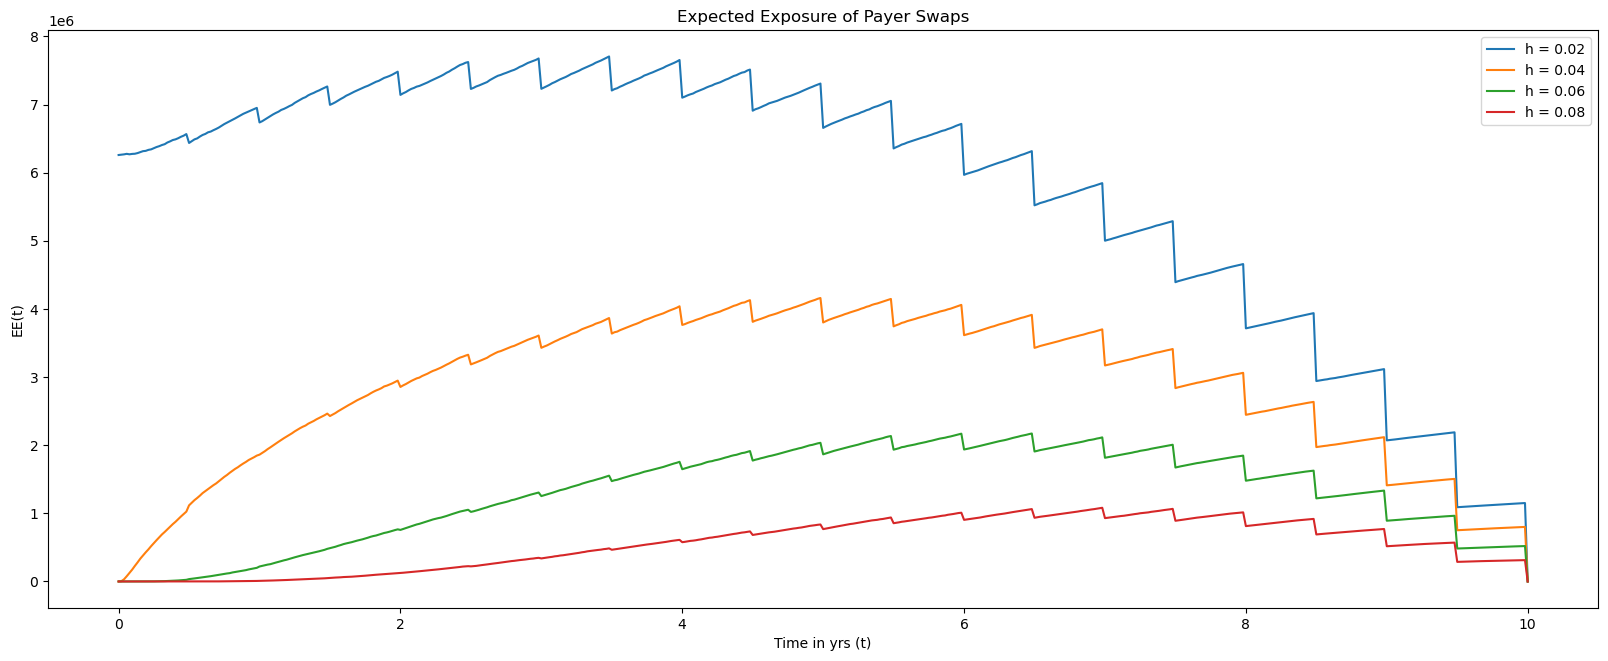

In [14]:
plt.figure(figsize=(20,7.5))
plt.title("Expected Exposure of Payer Swaps")
plt.xlabel("Time in yrs (t)")
plt.ylabel("EE(t)")

for i in range(len(h1)):
    plt.plot(ts, pEE[i], label= f'h = {h1[i]}')
    
plt.legend()
plt.show()

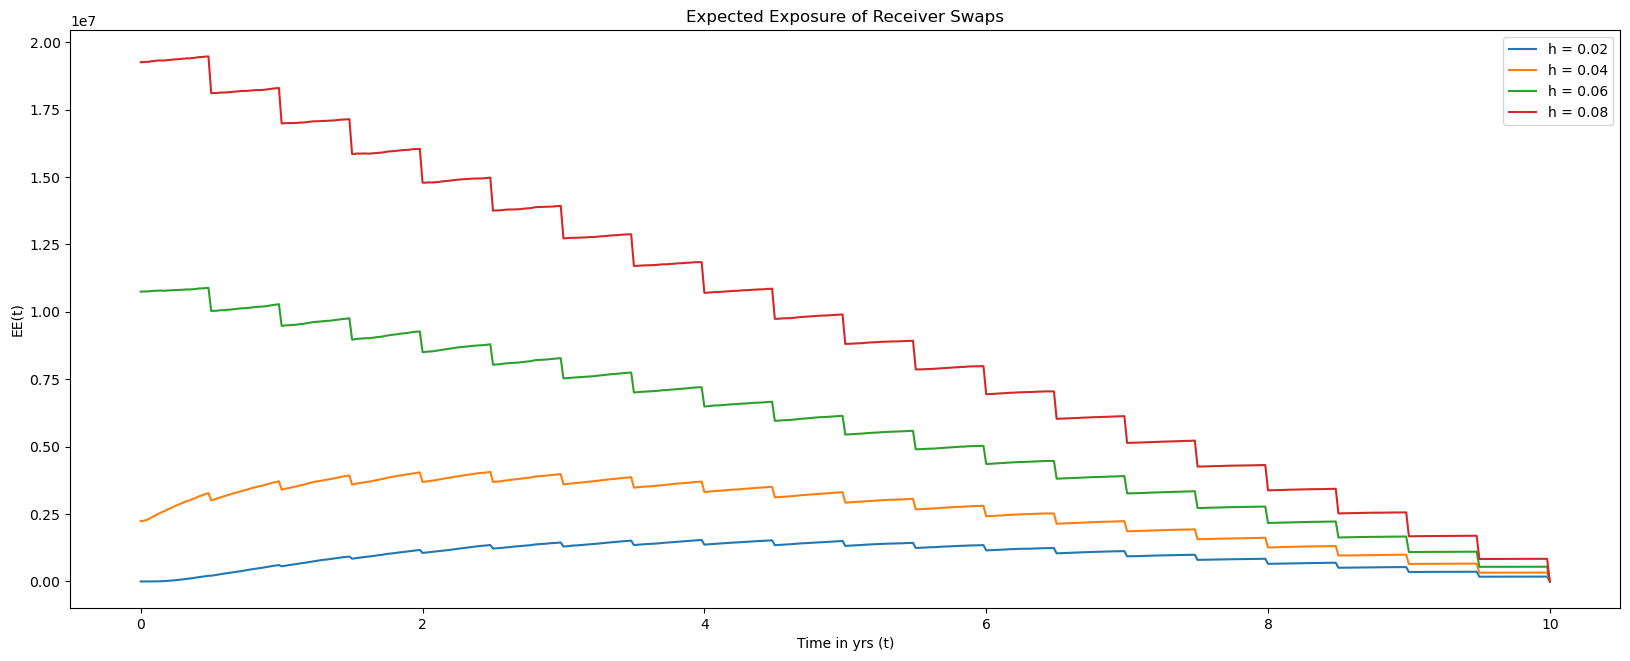

In [15]:
plt.figure(figsize=(20,7.5))
plt.title("Expected Exposure of Receiver Swaps")
plt.xlabel("Time in yrs (t)")
plt.ylabel("EE(t)")

for i in range(len(h1)):
    plt.plot(ts, rEE[i], label= f'h = {h1[i]}')
    
plt.legend()
plt.show()

## Question 2

**Repeat Q1, but now do the PVEE profiles, rather than the EE profiles.**

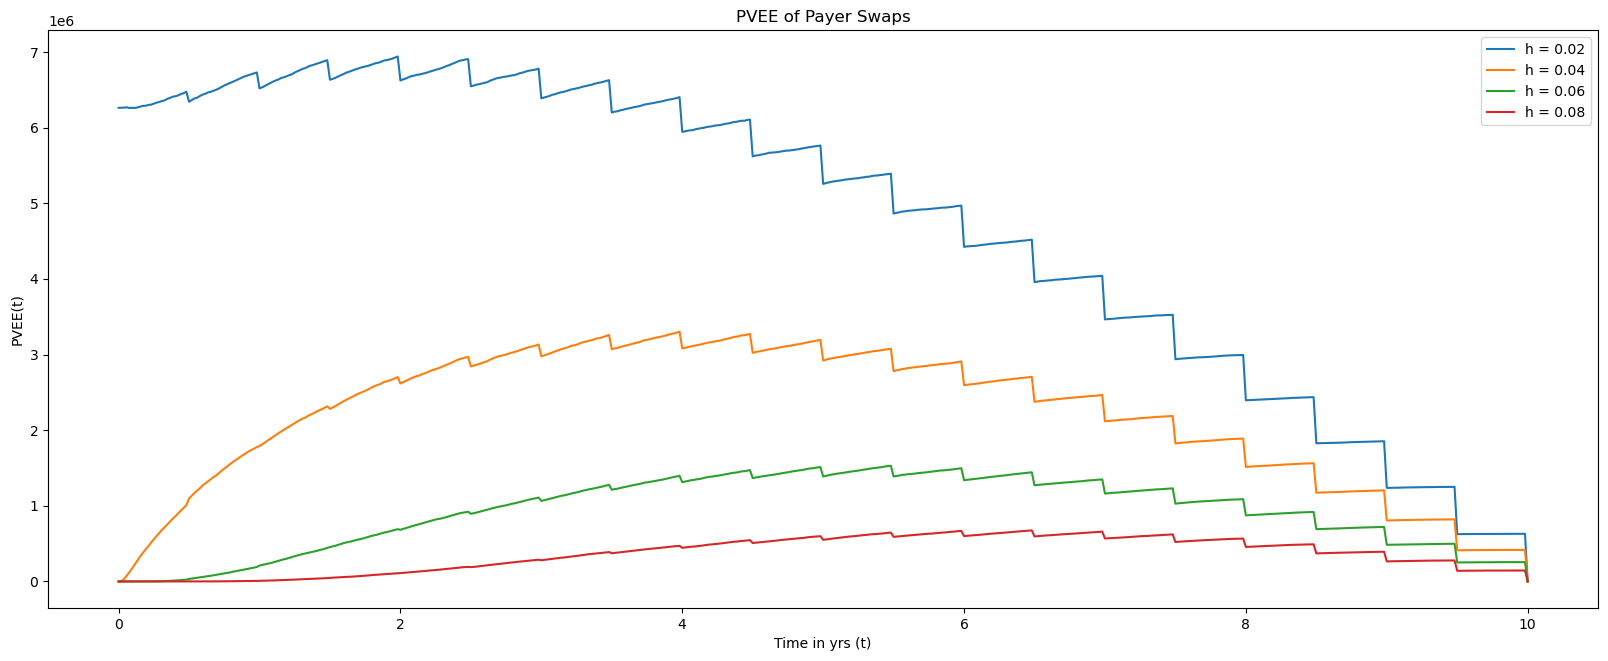

In [16]:
plt.figure(figsize=(20,7.5))
plt.title("PVEE of Payer Swaps")
plt.xlabel("Time in yrs (t)")
plt.ylabel("PVEE(t)")

for i in range(len(h1)):
    plt.plot(ts, pPVEE[i], label= f'h = {h1[i]}')
    
plt.legend()
plt.show()

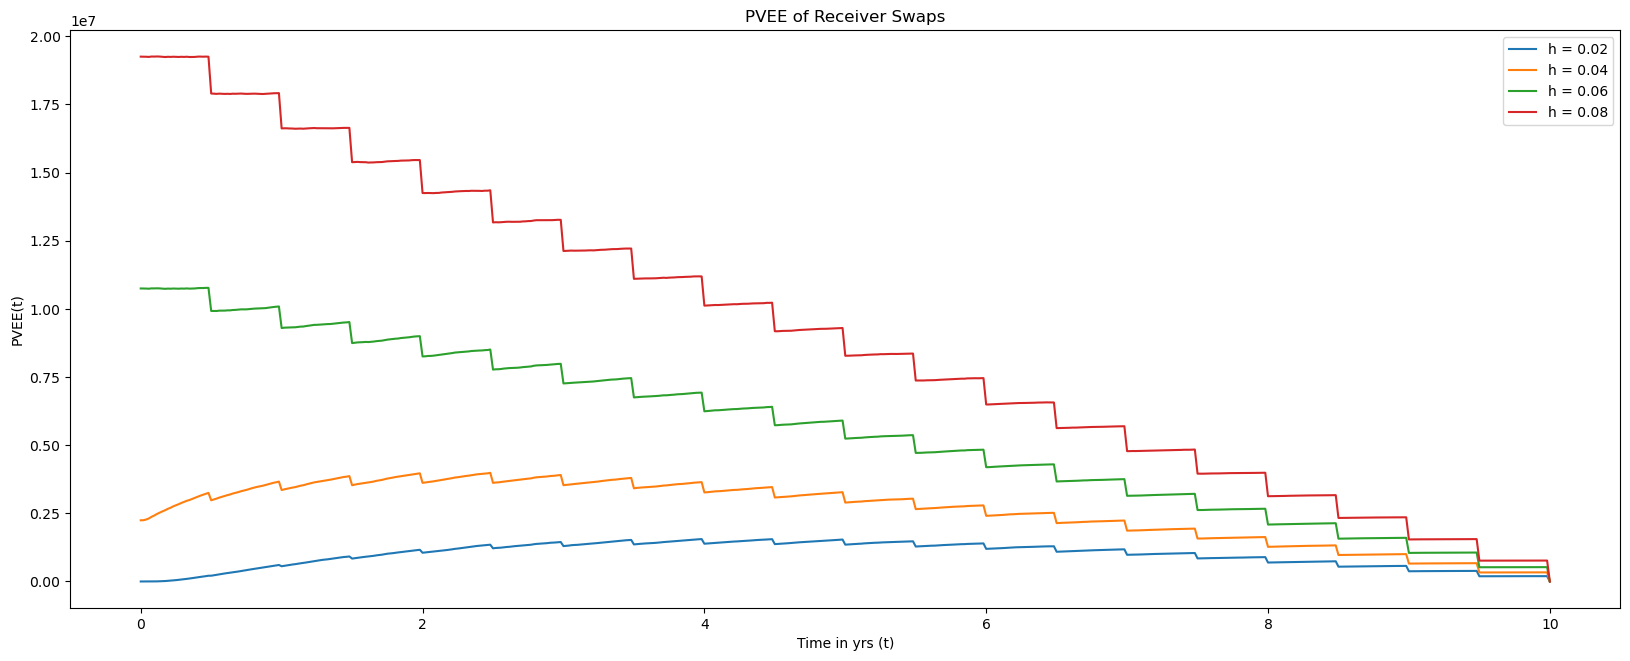

In [17]:
plt.figure(figsize=(20,7.5))
plt.title("PVEE of Receiver Swaps")
plt.xlabel("Time in yrs (t)")
plt.ylabel("PVEE(t)")

for i in range(len(h1)):
    plt.plot(ts, rPVEE[i], label= f'h = {h1[i]}')
    
plt.legend()
plt.show()

**In $Q1$ and $Q2$ there was no collateral. We now change this to assume that there is full variation margin (but no initial margin). Also assume that the swap is traded on an ISDA Master Agreement, and assume that the Margin Period of Risk (MPoR) is estimated at $\delta = 0.5$ months (so roughly 2 weeks). You can ignore complications from any unpaid cash flows, i.e. exposure for settlement time $t$ is $E(t) = (V(t)− V(t−\delta))^{+}$**

# Question 3

**Compute and graph the EE and PVEE profiles (weekly spacing) for the collateralized payer and receiver swaps.**

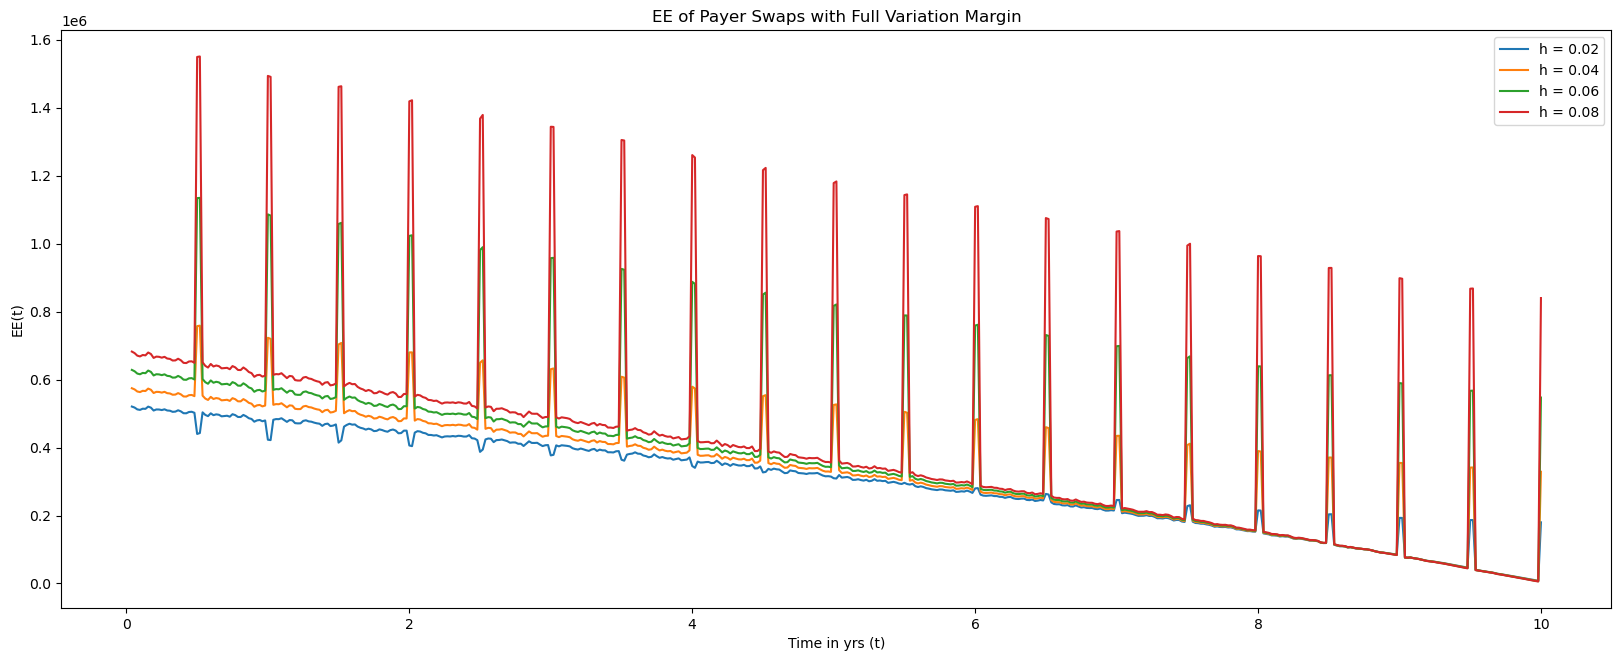

In [18]:
plt.figure(figsize=(20,7.5))
plt.title("EE of Payer Swaps with Full Variation Margin")
plt.xlabel("Time in yrs (t)")
plt.ylabel("EE(t)")

for i in range(len(h1)):
    plt.plot(ts[2:], pEE_VM[i][2:], label= f'h = {h1[i]}')
    
plt.legend()
plt.show()

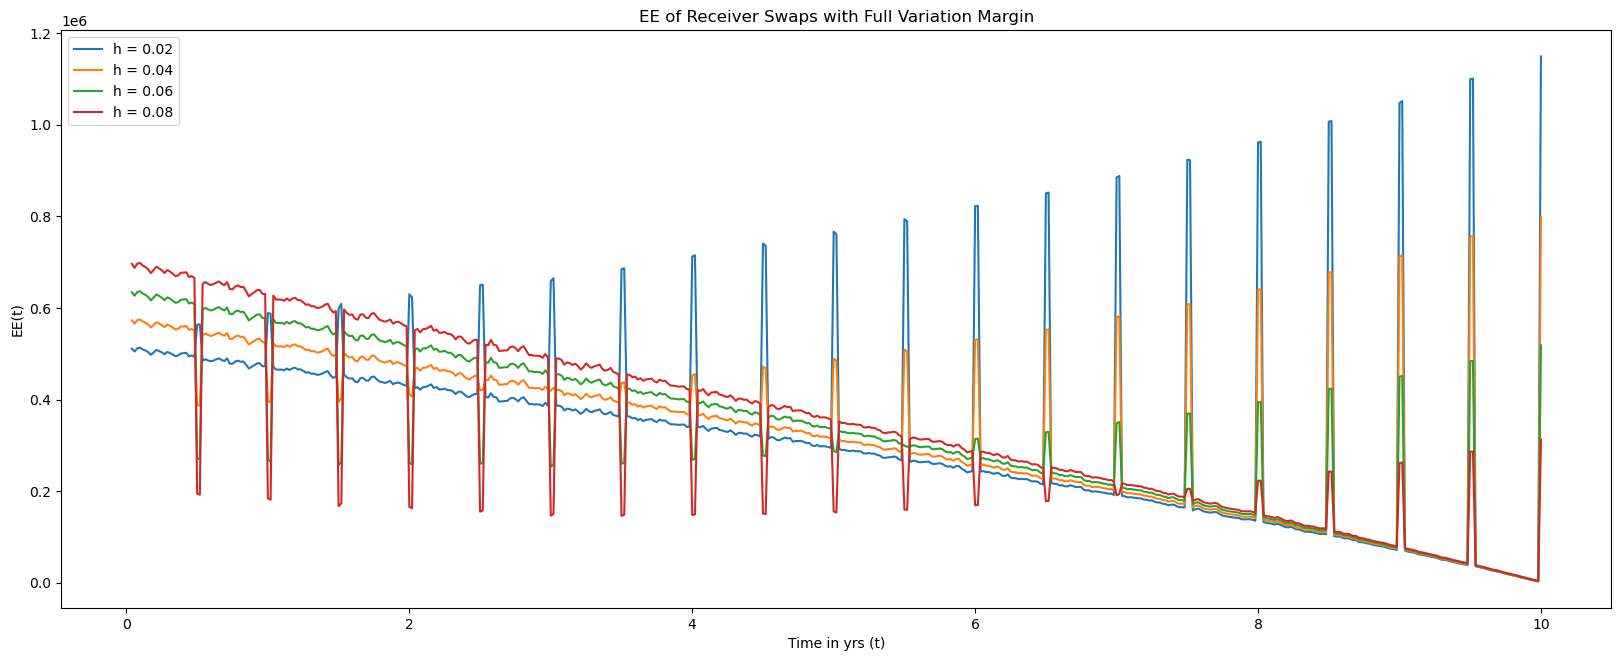

In [19]:
plt.figure(figsize=(20,7.5))
plt.title("EE of Receiver Swaps with Full Variation Margin")
plt.xlabel("Time in yrs (t)")
plt.ylabel("EE(t)")

for i in range(len(h1)):
    plt.plot(ts[2:], rEE_VM[i][2:], label= f'h = {h1[i]}')
    
plt.legend()
plt.show()

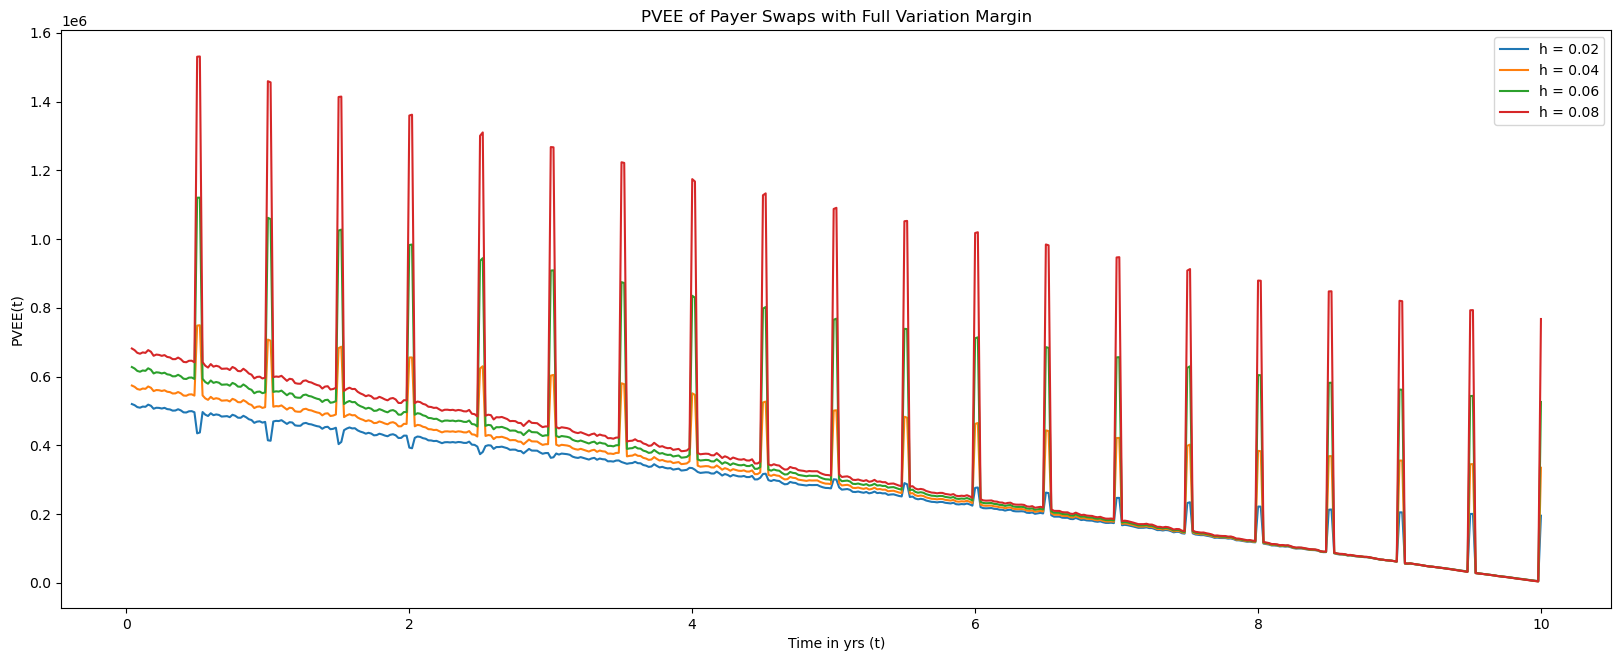

In [20]:
plt.figure(figsize=(20,7.5))
plt.title("PVEE of Payer Swaps with Full Variation Margin")
plt.xlabel("Time in yrs (t)")
plt.ylabel("PVEE(t)")

for i in range(len(h1)):
    plt.plot(ts[2:], pPVEE_VM[i][2:], label= f'h = {h1[i]}')
    
plt.legend()
plt.show()

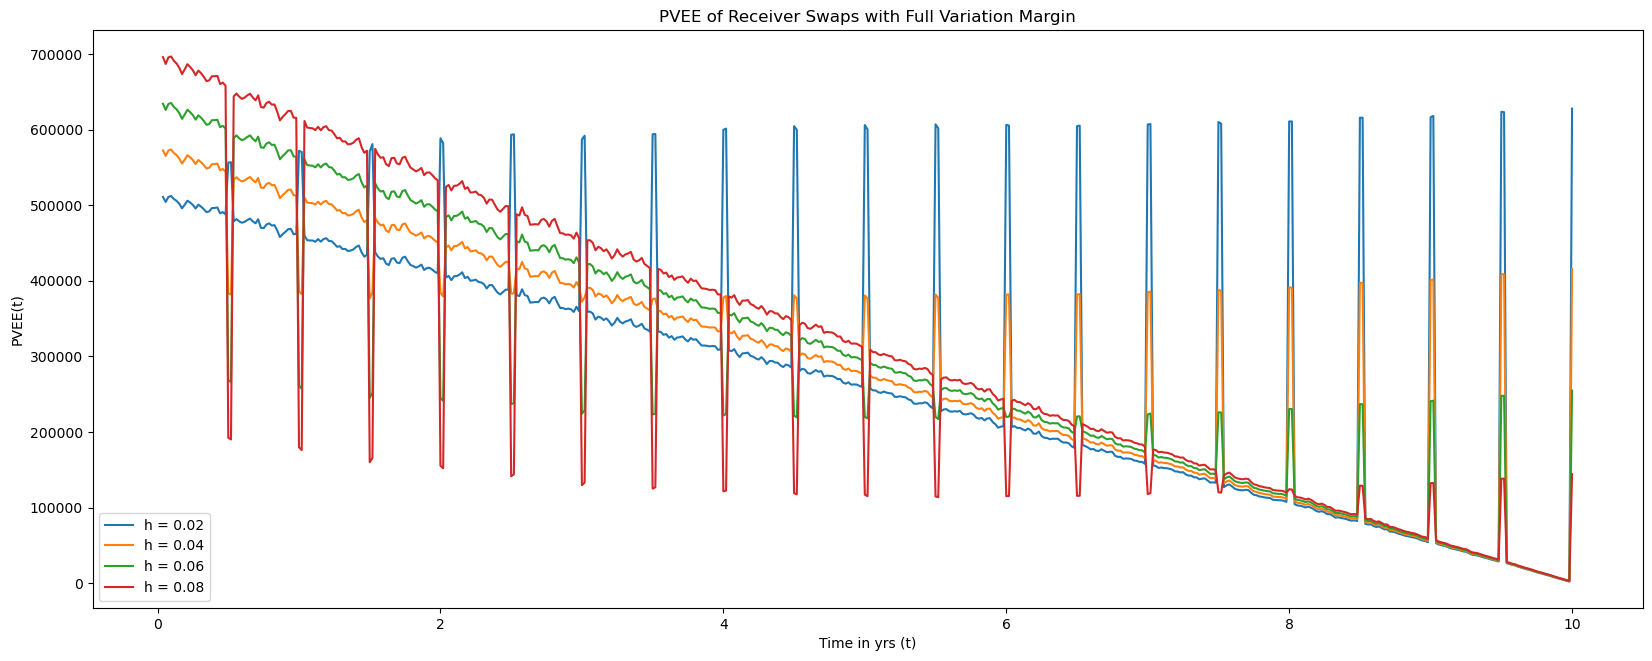

In [21]:
plt.figure(figsize=(20,7.5))
plt.title("PVEE of Receiver Swaps with Full Variation Margin")
plt.xlabel("Time in yrs (t)")
plt.ylabel("PVEE(t)")

for i in range(len(h1)):
    plt.plot(ts[2:], rPVEE_VM[i][2:], label= f'h = {h1[i]}')
    
plt.legend()
plt.show()

**Now set the coupon on the swap equal to its par rate hpar (computed in Coding Assignment 2). In addition to full variation margin, also add dynamic initial margin set at the confidence level $p$.**

## Question 4

**Using the scaling approximation from Lecture 7, show the EE profile on a weekly grid for $p = 80\%, 90\%, 99\%, 99.9\%$. 
It suffices to do this for the payer swap.**

In [22]:
p = np.array([0.8,0.9,0.99,0.999])

In [23]:
psi_p = (norm.pdf(norm.ppf(p)) - norm.ppf(p)*(1-p))*np.sqrt(2*np.pi)

In [24]:
swap_VM_IM = model3.SwapVal(x1_3,x2_3,h_par) * notional # Setting coupon = h_par
spvi = np.roll(swap_VM_IM, 2, axis=1)
swap_VM_IM_delta = spvi
pEE_VM_IM2 = np.zeros(len(p), dtype=object)
for i in range(len(p)):
    psi_p = (norm.pdf(norm.ppf(p[i])) - norm.ppf(p[i])*(1-p[i]))*np.sqrt(2*np.pi)
    pEE_VM_IM2[i] = np.mean(np.maximum(-(swap_VM_IM - swap_VM_IM_delta),0),axis=0) * psi_p  # Payer EE(t)

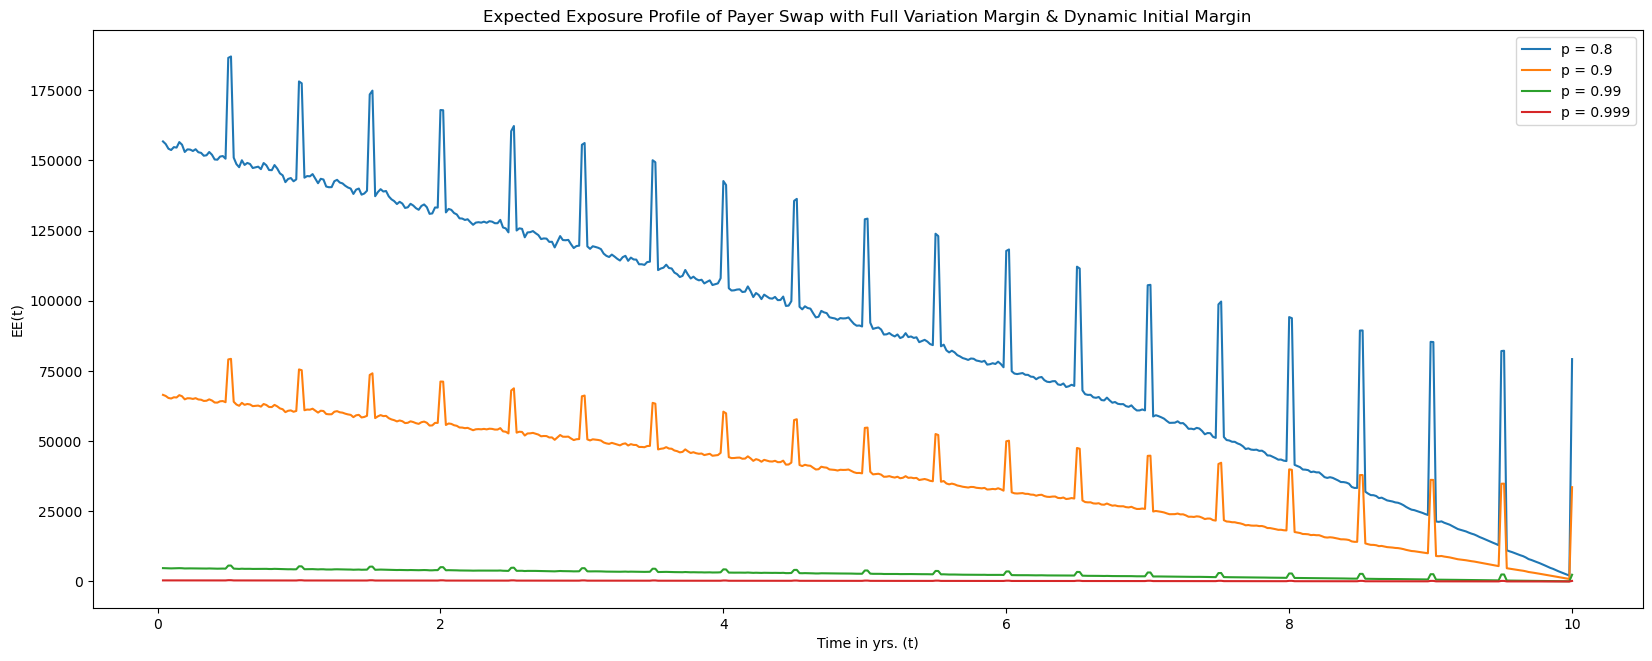

In [25]:
plt.figure(figsize=(20,7.5))
plt.title("Expected Exposure Profile of Payer Swap with Full Variation Margin & Dynamic Initial Margin")
plt.xlabel("Time in yrs. (t)")
plt.ylabel("EE(t)")

for i in range(len(p)):
    plt.plot(ts[2:],pEE_VM_IM2[i][2:], label=f'p = {p[i]}')

plt.legend()
plt.show()

**Assume that the swap is traded between a bank $B$ and client $A$. Suppose that the default intensity of $B$ is constant at $\lambda_{B} = 2\%$, and the default intensity of $A$ is constant at $\lambda_{A} = 4.5\%$. Assume that $B$ and $A$ both have recovery rates of $40\%$. We take the perspective of $B$.**

## Question 5

**Compute $B$’s unilateral CVA to $A$ for both payer and receiver swaps, at coupon rates of $h = 2\%, h = 4\%, h = 6\%, h = 8\%$. Do this with i) no collateral; ii) full variation margin; and iii) full variation margin and initial margin at level $p = 99\%$. As before, use a MPoR of $0.5$ months. Collect the result in a neat table and write some insightful comments on the magnitudes of the numbers.**

In [26]:
# Survival Probability
def X(lmbd,t,T):
    return np.exp(-lmbd*(T-t))

# CVA
def CVA(pPVEEvec, rPVEEvec, lA, lB, R, ts_, calc_type='unilateral'):
    pCVA = np.zeros((len(pPVEEvec), len(ts_)))
    rCVA = np.zeros((len(rPVEEvec), len(ts_)))
    XB = 1
    
    for i in range(2,len(ts_)):
        dXA = X(lA,0,ts[i]) - X(lA,0,ts[i-1])
        if calc_type == 'bilateral':
            XB = X(lB,0,ts_[i])
        pCVA[:,i] = pPVEEvec[:,i] * dXA * XB
        rCVA[:,i] = rPVEEvec[:,i] * dXA * XB
    pCVA *= -1*(1-R)
    rCVA *= -1*(1-R)
    return np.sum(pCVA, axis=1), np.sum(rCVA, axis=1)

In [27]:
# Client A
lambdaA = 0.045 # Default Intensity
RA      = 0.4   # Recovery Rate

# Bank B
lambdaB = 0.02  # Default Intensity
RB      = 0.4   # Recovery Rate

In [28]:
Uni_pCVA = pd.DataFrame({'Coupon':['2%','4%','6%','8%'], 
                    'No Collateral': CVA(pPVEE,rPVEE,lambdaA,lambdaB,RA,ts,calc_type='unilateral')[0], 
                    'VM': CVA(pPVEE_VM,rPVEE_VM,lambdaA,lambdaB,RA,ts,calc_type='unilateral')[0], 
                    'VM + IM': CVA(pPVEE_VM_IM,rPVEE_VM_IM,lambdaA,lambdaB,RA,ts,calc_type='unilateral')[0]})
Uni_pCVA = Uni_pCVA.set_index('Coupon')
pd.options.display.float_format = '{:,.2f}'.format
print("Unilateral CVA Values for Payer Swap for different scenarios: ")
Uni_pCVA

Unilateral CVA Values for Payer Swap for different scenarios: 


,No Collateral,VM,VM + IM
Coupon,,,
2%,"1,085,664.56","63,134.26",536.27
4%,"483,577.38","70,489.92",598.75
6%,"195,670.40","78,855.33",669.81
8%,"74,736.19","88,072.10",748.09


In [29]:
Uni_rCVA = pd.DataFrame({'Coupon':['2%','4%','6%','8%'], 
                    'No Collateral': CVA(pPVEE,rPVEE,lambdaA,lambdaB,RA,ts,calc_type='unilateral')[1], 
                    'VM': CVA(pPVEE_VM,rPVEE_VM,lambdaA,lambdaB,RA,ts,calc_type='unilateral')[1], 
                    'VM + IM': CVA(pPVEE_VM_IM,rPVEE_VM_IM,lambdaA,lambdaB,RA,ts,calc_type='unilateral')[1]})
Uni_rCVA = Uni_rCVA.set_index('Coupon')
pd.options.display.float_format = '{:,.2f}'.format
print("Unilateral CVA Values for Receiver Swap for different scenarios: ")
Uni_rCVA

Unilateral CVA Values for Receiver Swap for different scenarios: 


,No Collateral,VM,VM + IM
Coupon,,,
2%,"212,699.44","65,224.51",554.02
4%,"589,117.38","66,656.21",566.19
6%,"1,279,715.51","69,097.65",586.92
8%,"2,137,286.42","72,390.46",614.89


## Question 6

**Repeat Q5, but now for $B$’s bilateral CVA**

In [30]:
Bi_pCVA = pd.DataFrame({'Coupon':['2%','4%','6%','8%'], 
                    'No Collateral': CVA(pPVEE,rPVEE,lambdaA,lambdaB,RA,ts,calc_type='bilateral')[0], 
                    'VM': CVA(pPVEE_VM,rPVEE_VM,lambdaA,lambdaB,RA,ts,calc_type='bilateral')[0], 
                    'VM + IM': CVA(pPVEE_VM_IM,rPVEE_VM_IM,lambdaA,lambdaB,RA,ts,calc_type='bilateral')[0]})
Bi_pCVA = Bi_pCVA.set_index('Coupon')
pd.options.display.float_format = '{:,.2f}'.format
print("Bilateral CVA Values for Payer Swap for different scenarios: ")
Bi_pCVA

Bilateral CVA Values for Payer Swap for different scenarios: 


,No Collateral,VM,VM + IM
Coupon,,,
2%,"1,010,868.28","59,225.46",503.07
4%,"443,446.86","66,140.34",561.80
6%,"176,624.51","73,976.17",628.36
8%,"66,559.94","82,584.48",701.48


In [31]:
Bi_rCVA = pd.DataFrame({'Coupon':['2%','4%','6%','8%'], 
                    'No Collateral': CVA(pPVEE,rPVEE,lambdaA,lambdaB,RA,ts,calc_type='bilateral')[1], 
                    'VM': CVA(pPVEE_VM,rPVEE_VM,lambdaA,lambdaB,RA,ts,calc_type='bilateral')[1], 
                    'VM + IM': CVA(pPVEE_VM_IM,rPVEE_VM_IM,lambdaA,lambdaB,RA,ts,calc_type='bilateral')[1]})
Bi_rCVA = Bi_rCVA.set_index('Coupon')
pd.options.display.float_format = '{:,.2f}'.format
print("Bilateral CVA Values for Receiver Swap for different scenarios: ")
Bi_rCVA

Bilateral CVA Values for Receiver Swap for different scenarios: 


,No Collateral,VM,VM + IM
Coupon,,,
2%,"194,240.73","61,033.85",518.43
4%,"547,851.87","62,549.75",531.31
6%,"1,202,062.08","64,986.61",552.00
8%,"2,013,030.06","68,195.94",579.26


* The magnitude of CVA (for uni- and bi-lateral calculations) decreases drastically as more collateral is introduced. This is because our Expected Exposure is less due to introduction of margin.
* Our Expected Exposure increases with increasing coupon rate (as visible in above plots), the increased credit risk thereby increases the value of CVA

As seen in the exposure profile, the payer has the most exposure at a 2% coupon and the least at a 8% coupon. The receiver is the opposite, with the most exposure at a 8% coupon and the least at 2%. The CVA value is proportional to the expected positive exposure of the trade. Including variation margin, the exposure of the trade to the forward two week period is significantly reduced ; moreover, the receiver and payer have similar exposure profiles. With Initial Margin, CVA is reduced to a very small amount as expected.

**We now turn to FVA and MVA computations. Let the credit spread of bank B be constant at $s_{B} = 1.2\%$. We recall that positions with full VM is associated with no FVA, so we only need to compute FVA for the uncollateralized swap; it is zero for the collateralized swaps. MVA is associated with positions that have initial margin.**

## Question 7

**Compute B’s FVA for the uncollateralized swap position, for both payer and receiver swaps. Do the calculation for $h = 2\%, h = 4\%, h = 6\%, h = 8\%$. Show results in a table, and comment on the signs of the numbers. Specifically explain why are some of the numbers are negative.**

In [32]:
def FVA(pPVEEvec,rPVEEvec,ts_,lB,spread):
    FCA = np.zeros((len(pPVEEvec),len(ts_)))
    FBA = np.zeros((len(pPVEEvec),len(ts_)))
    
    for i in range(2,len(ts_)):
        FCA[:,i] = rPVEEvec[:,i] * spread * X(lB,0,ts_[i]) * (ts_[i]-ts_[i-1])
        FBA[:,i] = pPVEEvec[:,i] * spread * X(lB,0,ts_[i]) * (ts_[i]-ts_[i-1])
        
    return np.sum(FCA,axis=1) - np.sum(FBA,axis=1)

In [33]:
SB = 0.012

In [34]:
B_FVA = pd.DataFrame({'Coupon':['2%','4%','6%','8%'], 
                    'Payer': FVA(pPVEE,rPVEE,ts,lambdaB,SB), 
                    'Receiver': -1*FVA(pPVEE,rPVEE,ts,lambdaB,SB)})
B_FVA = B_FVA.set_index('Coupon')
pd.options.display.float_format = '{:,.2f}'.format
print("FVA Values for Payer & Receiver Swap for B: ")
B_FVA

FVA Values for Payer & Receiver Swap for B: 


,Payer,Receiver
Coupon,,
2%,"-422,887.35","422,887.35"
4%,"47,370.22","-47,370.22"
6%,"517,627.80","-517,627.80"
8%,"987,885.38","-987,885.38"


* FVA values are negative when FBA > FCA, i.e. essentially when B is receiving funding from its counterparty (short derivative). This is visible when the coupon rate is lesser than h
* For example, if B to entice B to enter a receiver swap at 2% coupon when the hpar is 3.4%, the counterparty has to pay B to conduct this trade (basically compensate). Using this cash B can theoretically extinguish its outstanding debt. Hence funding cost will be less than funding benefit
* The inverse would be true if we are paying a coupon lower than hpar or we were the receiver in the swap described above. The payer FVA and receiver FVA change between positive and negative values above the hpar rate because of the cost of carry on the trade

## Question 8

**Use the scaling results in Lecture 9 to compute MVA for the swap with full VM and IM at level $p = 99\%$. Do this for both payer and receiver swaps, $h = 2\%, h = 4\%, h = 6\%, h = 8\%$. Collect the results in a table and explain whether the drop in CVA from the introduction of IM (can be gleaned from the results of Q5 above) justify the MVA cost to $B$’s shareholders.**

In [35]:
def MVA(pPVEEvec,rPVEEvec,ts_,lB,spread):
    pMVA = np.zeros((len(pPVEEvec),len(ts_)))
    rMVA = np.zeros((len(rPVEEvec),len(ts_)))
    
    for i in range(1,len(ts_)):
        pMVA[:,i] = pPVEEvec[:,i] * spread * X(lB,0,ts_[i]) * (ts_[i]-ts_[i-1])
        rMVA[:,i] = rPVEEvec[:,i] * spread * X(lB,0,ts_[i]) * (ts_[i]-ts_[i-1])
    
    scale_factor = (norm.ppf(0.99)) * np.sqrt(2 * np.pi)
    return np.sum(pMVA,axis=1)*scale_factor, np.sum(rMVA,axis=1)*scale_factor 

In [36]:
B_MVA = pd.DataFrame({'Coupon':['2%','4%','6%','8%'], 
                    'Payer': MVA(pPVEE_VM,rPVEE_VM,ts,lambdaB,SB)[0], 
                    'Receiver': MVA(pPVEE_VM,rPVEE_VM,ts,lambdaB,SB)[1]})
B_MVA = B_MVA.set_index('Coupon')
pd.options.display.float_format = '{:,.2f}'.format
print("MVA Values for Payer & Receiver Swap for B: ")
B_MVA

MVA Values for Payer & Receiver Swap for B: 


,Payer,Receiver
Coupon,,
2%,"186,134.60","184,217.02"
4%,"198,373.42","190,588.02"
6%,"221,971.53","208,318.29"
8%,"248,075.79","228,554.73"


* The shareholder's MVA cost is **not** justifiable to bring down the CVA value since the magnitude of decrease in the CVA values is less than the magnitude of MVA. In order to reduce CVA from roughly ten thousands to hundreds an MVA charge of roughly $\$180,000$ has been created. The MVA ends up being over ~360x greater than the CVA with variation margin and initial margin (at $p=99\%$); this is difficult to justify on economic terms, but is required by regulation.